In [ ]:
!pip install transformers torch sklearn pandas openpyxl matplotlib scikit-plot


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Kütüphaneleri içe aktar
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_score, recall_score, f1_score
)
from torch.optim import AdamW
from transformers import get_scheduler
import seaborn as sns

In [ ]:
# Veri seti yollarını tanımla
train_path = "/content/drive/MyDrive/30_data_set/30_test/sorted_final_merged_test.xlsx"
test_path = "/content/drive/MyDrive/30_data_set/30_train/sorted_final_merged_train.xlsx"

# Veri setlerini yükle
train_data = pd.read_excel(train_path)
test_data = pd.read_excel(test_path)

In [ ]:
# Veri seti sınıfını tanımla
from torch.utils.data import Dataset

class PoetryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Text'in doğru türde olduğunu kontrol et
        if not isinstance(text, str):
            print(f"Invalid text at index {idx}: {text} (type: {type(text)})")
            raise ValueError("Text must be of type 'str'")

        encoded = self.tokenizer(
            text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


In [ ]:
# Tokenizer ve model başlatma
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Veri setlerini hazırla
train_dataset = PoetryDataset(
    train_data["poem_text"].tolist(), train_data["label"].tolist(), tokenizer
)
test_dataset = PoetryDataset(
    test_data["poem_text"].tolist(), test_data["label"].tolist(), tokenizer
)

# Veri yükleyicileri hazırla
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Optimizasyon ve öğrenme oranı zamanlayıcıyı tanımla
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 10  # 10 epoch
num_warmup_steps = int(0.1 * num_training_steps)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)


In [ ]:
train_data['poem_text'] = train_data['poem_text'].astype(str)
test_data['poem_text'] = test_data['poem_text'].astype(str)


In [ ]:
# Verileri kontrol ve temizleme
# NaN veya float turundeki hatali verileri temizler

def clean_dataset(data):
    # NaN degerlerini temizle
    data = data.dropna(subset=['poem_text'])

    # String olmayan verileri temizle
    data = data[data['poem_text'].apply(lambda x: isinstance(x, str))]

    # Verilerin resetlenmesi
    data = data.reset_index(drop=True)
    return data

# Test verisini temizle
test_data = clean_dataset(test_data)

def calculate_inference_time(model, test_loader, device):
    model.eval()  # Modeli değerlendirme moduna al
    total_inference_time = 0
    total_batches = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            start_time = time.time()
            outputs = model(input_ids, attention_mask=attention_mask)
            end_time = time.time()

            total_inference_time += (end_time - start_time)
            total_batches += 1

    average_inference_time = total_inference_time / total_batches
    print(f"Toplam inference süresi: {total_inference_time:.4f} saniye")
    print(f"Ortalama inference süresi (batch başına): {average_inference_time:.4f} saniye")

    return total_inference_time, average_inference_time

# Veri temizliği sonrası test loader'ı yeniden oluştur
from torch.utils.data import DataLoader

test_dataset = PoetryDataset(
    test_data["poem_text"].tolist(), test_data["label"].tolist(), tokenizer
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Cihaz ve model tanımı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Çıkarım süresini hesapla
calculate_inference_time(model, test_loader, device)


Toplam inference süresi: 3.6655 saniye
Ortalama inference süresi (batch başına): 0.0051 saniye


(3.665452003479004, 0.005105086355820339)

In [ ]:
# Eğitim ve Doğrulama Kayıpları için Değişkenler
training_losses = []
validation_losses = []

# Early Stopping ve Model Kaydetme için Değişkenler
best_val_loss = float("inf")
patience_counter = 0
patience_limit = 3  # Validation loss artışına tolerans
best_model_path = "/content/drive/MyDrive/best_distilbert_model"

# Eğitim döngüsü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
start_training_time = time.time()

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)

    # Doğrulama aşaması
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Kontrolü
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Modelin en iyi halini kaydet
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
        print(f"Yeni en iyi model kaydedildi: {best_model_path}")
    else:
        patience_counter += 1
        print(f"Validation loss arttı ({patience_counter}/{patience_limit})")

    if patience_counter >= patience_limit:
        print("Early stopping triggered. Eğitim durduruldu.")
        break

end_training_time = time.time()
training_time = end_training_time - start_training_time
print(f"Eğitim Zamanı: {training_time:.2f} saniye")

Epoch 1 - Training Loss: 0.1652, Validation Loss: 0.5667
Yeni en iyi model kaydedildi: /content/drive/MyDrive/best_distilbert_model
Epoch 2 - Training Loss: 0.2423, Validation Loss: 0.6521
Validation loss arttı (1/3)
Epoch 3 - Training Loss: 0.1451, Validation Loss: 0.5917
Validation loss arttı (2/3)
Epoch 4 - Training Loss: 0.1041, Validation Loss: 0.6811
Validation loss arttı (3/3)
Early stopping triggered. Eğitim durduruldu.
Eğitim Zamanı: 407.59 saniye


In [ ]:
# Modeli Google Drive'a kaydet
model_save_path = "/content/drive/MyDrive/best_distilbert_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model Google Drive'a kaydedildi: {model_save_path}")


Model Google Drive'a kaydedildi: /content/drive/MyDrive/best_distilbert_model


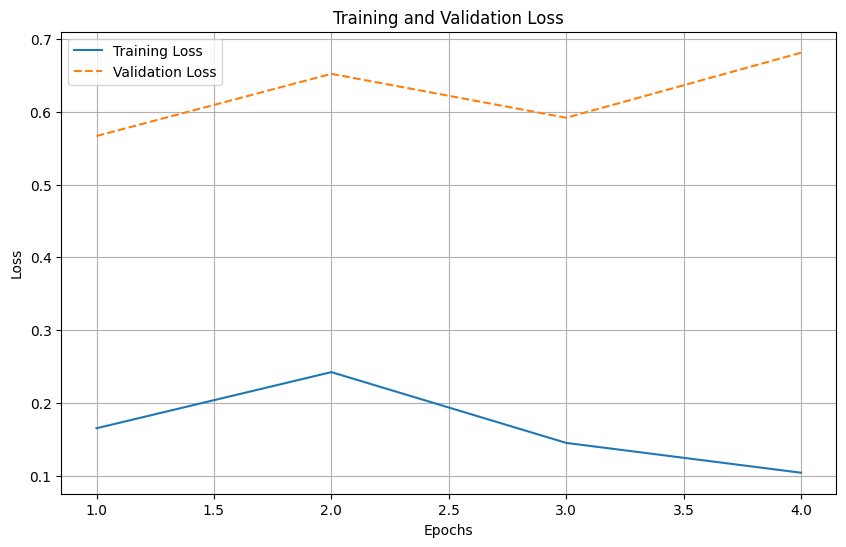

In [ ]:
# Eğitim ve doğrulama kayıplarını aynı grafikte çizdirme
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", linestyle="--")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
true_labels = []
predictions = []

model.eval()  # Modeli değerlendirme moduna al
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Gerçek etiketleri ve tahminleri listeye ekle
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())


Doğruluk: 0.8325063114825455
Kesinlik (Precision): 0.8342187132689233
Duyarlılık (Recall): 0.8325063114825455
F1-Skoru: 0.832065274966295
AUC: 0.8953174829661322


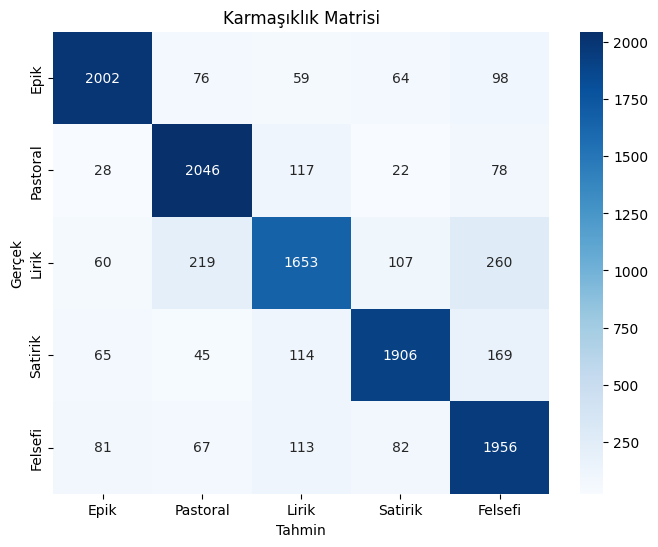

Sensitivity ve Specificity Sonuçları:
Class 0: {'Sensitivity': 0.8708133971291866, 'Specificity': 0.9745319982585982}
Class 1: {'Sensitivity': 0.8930597992143169, 'Specificity': 0.9557416267942583}
Class 2: {'Sensitivity': 0.71900826446281, 'Specificity': 0.9561384414453635}
Class 3: {'Sensitivity': 0.829056111352762, 'Specificity': 0.9700696560731389}
Class 4: {'Sensitivity': 0.8508046976946498, 'Specificity': 0.9341532433609055}


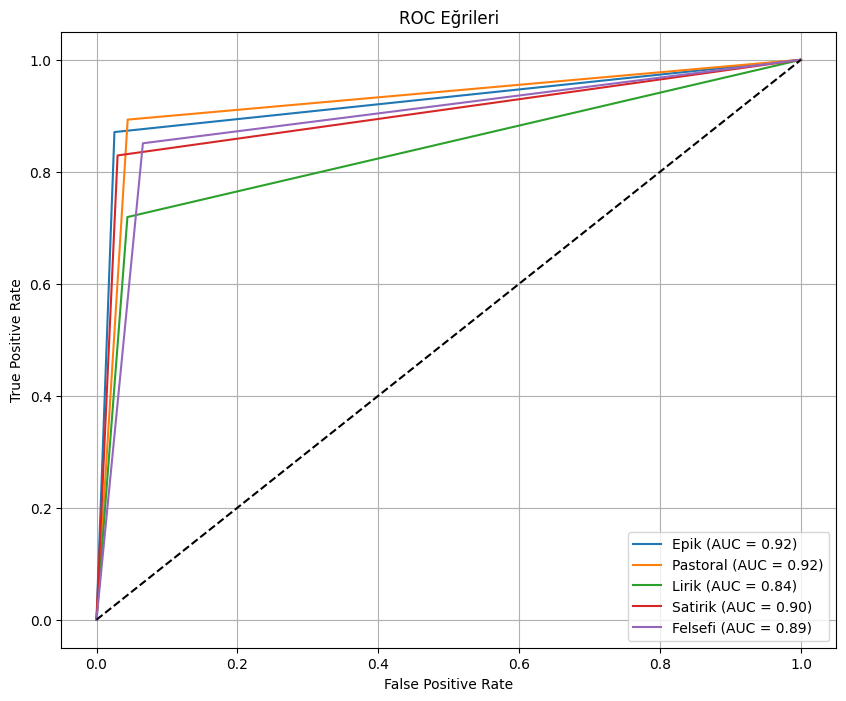

In [ ]:
from sklearn.metrics import roc_curve


# Performans metrikleri
categories = ["Epik", "Pastoral", "Lirik", "Satirik", "Felsefi"]


accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predictions), average='weighted', multi_class='ovr')

print("Doğruluk:", accuracy)
print("Kesinlik (Precision):", precision)
print("Duyarlılık (Recall):", recall)
print("F1-Skoru:", f1)
print("AUC:", auc)

# Karmaşıklık Matrisi
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Epik", "Pastoral", "Lirik", "Satirik", "Felsefi"], yticklabels=["Epik", "Pastoral", "Lirik", "Satirik", "Felsefi"])
plt.title("Karmaşıklık Matrisi")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()


# Sensitivity ve Specificity hesaplama fonksiyonu
def compute_sensitivity_specificity(confusion_matrix):
    # True Positive, False Positive, True Negative, False Negative hesaplama
    sensitivity_specificity = {}
    for i in range(len(confusion_matrix)):
        TP = confusion_matrix[i, i]
        FN = confusion_matrix[i, :].sum() - TP
        FP = confusion_matrix[:, i].sum() - TP
        TN = confusion_matrix.sum() - (TP + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        sensitivity_specificity[f"Class {i}"] = {"Sensitivity": sensitivity, "Specificity": specificity}
    return sensitivity_specificity
# Sensitivity ve Specificity Hesaplaması
sensitivity_specificity = compute_sensitivity_specificity(cm)
print("Sensitivity ve Specificity Sonuçları:")
for cls, metrics in sensitivity_specificity.items():
    print(f"{cls}: {metrics}")




from sklearn.metrics import roc_curve, auc
# Gerçek etiketlerin ve tahminlerin binarize edilmesi
y_true_bin = label_binarize(true_labels, classes=list(range(len(categories))))
y_pred_bin = label_binarize(predictions, classes=list(range(len(categories))))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])  # 'auc' fonksiyonu artık doğru şekilde çalışacak.

# Her sınıf için ROC eğrisi çizimi
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], label=f'{category} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrileri')
plt.legend(loc='best')
plt.grid()
plt.show()




In [ ]:
# Model ve tokenizer yükleme
model.eval()  # Modeli değerlendirme moduna al

# Tahmin fonksiyonu
def predict_poem_category(poem_text, model, tokenizer, categories, max_length=512):
    # Text'i token'lara dönüştür
    encoded = tokenizer(
        poem_text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Modelden tahmin al
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Tahmini kategori adıyla döndür
    return categories[predicted_class]

# Kategori etiketleri
categories = ["Epik", "Pastoral", "Lirik", "Satirik", "Felsefi"]

# Örnek bir şiir için tahmin
sample_poem = """
Gökyüzü masmavi bir deniz,
Rüzgar serin, kalbim serin...
Toprak kokusu ciğerimde.
"""
predicted_category = predict_poem_category(sample_poem, model, tokenizer, categories)
print(f"Tahmin edilen kategori: {predicted_category}")


Tahmin edilen kategori: Pastoral
